In [54]:
#FCN SEGMENTATION
import matplotlib.image as img
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
import math
import os
from keras import layers
from keras.layers import Dropout,Input,Concatenate, Cropping2D,merge,Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,Lambda,Convolution2D,Conv2DTranspose,UpSampling2D,SeparableConv2D,DepthwiseConv2D
from keras.models import Model, load_model,Sequential
from keras.layers.merge import concatenate
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.optimizers import SGD
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
import scipy.misc
import h5py
import keras.backend as K
import matplotlib.image as img
from keras.callbacks import ModelCheckpoint
from keras.utils import multi_gpu_model
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"
import keras
import keras.backend.tensorflow_backend as KTF
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
#进行配置，使用30%的GPU
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.95
# session = tf.Session(config=config)

# # 设置session
# KTF.set_session(session )


In [55]:
###################################################################################################################
#####################################################Nail segment######################################################
def nail_segnet(input_shape=(256, 256, 3),num_classes=1):
    inputs = Input(shape=input_shape)
    c1 = Conv2D(16, 3, activation='relu', padding='same') (inputs)
    c1 = Conv2D(16, 3, activation='relu', padding='same') (c1)
    p1 = MaxPooling2D() (c1)
    c2 = Conv2D(32, 3, activation='relu', padding='same') (p1)
    c2 = Conv2D(32, 3, activation='relu', padding='same') (c2)
    p2 = MaxPooling2D() (c2)
    c3 = Conv2D(64, 3, activation='relu', padding='same') (p2)
    c3 = Conv2D(64, 3, activation='relu', padding='same') (c3)
    p3 = MaxPooling2D() (c3)
    c4 = Conv2D(128, 3, activation='relu', padding='same') (p3)
    c4 = Conv2D(128, 3, activation='relu', padding='same') (c4)
    p4 = MaxPooling2D() (c4)
    c5 = Conv2D(256, 3, activation='relu', padding='same') (p4)
    c5 = Conv2D(256, 3, activation='relu', padding='same') (c5)
    u6 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same') (c5)
    u6 = Concatenate(axis=3)([u6, c4])
    c6 = Conv2D(128, 3, activation='relu', padding='same') (u6)
    c6 = Conv2D(128, 3, activation='relu', padding='same') (c6)
    u7 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same') (c6)
    u7 = Concatenate(axis=3)([u7, c3])
    c7 = Conv2D(64, 3, activation='relu', padding='same') (u7)
    c7 = Conv2D(64, 3, activation='relu', padding='same') (c7)
    u8 = Conv2DTranspose(16, 2, strides=(2, 2), padding='same') (c7)
    u8 = Concatenate(axis=3)([u8, c2])
    c8 = Conv2D(32, 3, activation='relu', padding='same') (u8)
    c8 = Conv2D(32, 3, activation='relu', padding='same') (c8)
    u9 = Conv2DTranspose(8, 2, strides=(2, 2), padding='same') (c8)
    u9 = Concatenate(axis=3)([u9, c1])
    c9 = Conv2D(16, 3, activation='relu', padding='same') (u9)
    c9 = Conv2D(16, 3, activation='relu', padding='same') (c9)
    classify = Conv2D(1, 1, activation='sigmoid') (c9)
    model = Model(inputs=inputs, outputs=classify)
    return model


In [56]:
# def mean_iou(y_true, y_pred):
#     yt0 = y_true[:,:,:,0]
#     yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
#     inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
#     union = tf.count_nonzero(tf.add(yt0, yp0))
#     iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
#     return iou
def IoU_fun(eps=1e-6):
    def IoU(y_true, y_pred):
        # if np.max(y_true) == 0.0:
        #     return IoU(1-y_true, 1-y_pred) ## empty image; calc IoU of zeros
        intersection = K.sum(y_true * y_pred, axis=[1,2,3])
        union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
        #
        ious=K.mean((intersection + eps) / (union + eps),axis=0)
        return K.mean(ious)
    return IoU
def IoU_loss(y_true,y_pred):
    eps=1e-6
    return 1 - IoU_fun(eps=eps)(y_true=y_true,y_pred=y_pred)
#     return 1-IoU_fun(eps=eps)(y_true=y_true,y_pred=y_pred)

# def iou(y_true, y_pred):
#     insertssion = (y_true * y_pred)
#     union = y_true + y_pred - insertssion
#     return K.sum(insertssion) / K.sum(union)
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def fix_mask(mask):
    mask[mask < 100] = 0.0
    mask[mask >= 100] = 255.0
def input_data():  
    path_x = "data/train/nx/"
    path_y = "data/train/ny/"
    train_num =1000#sum([len(x) for _, _, x in os.walk(os.path.dirname(path_x))])  
    image_train = np.zeros((train_num,256,256,3)) 
    label_train = np.zeros((train_num,256,256,1)) 
    count = 0
    for i in range(train_num):
        img = image.load_img(path_x + str(i) + ".bmp", target_size = (256, 256))
        x = image.img_to_array(img)
        gray = x.reshape((256,256,3))                
        image_train[count] = gray 
        img = image.load_img(path_y + str(i) + ".bmp", target_size = (256, 256))
        x = image.img_to_array(img)
        gray = rgb2gray(x)
        gray = gray.reshape((256,256,1))                                
        label_train[count] = gray
        count = count + 1
    return image_train, label_train



In [57]:
image_train, label_train = input_data()  
image_train = image_train.astype('float32')
label_train = label_train.astype('float32')
K.clear_session()
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                    patience=3, min_lr=0.00002)
model = nail_segnet(num_classes = 1)
model.summary()
model.compile(optimizer = "adam", loss = "binary_crossentropy",  metrics = [IoU_loss])
checkpoint = ModelCheckpoint(filepath='model/nail_segment.h5',monitor='val_acc',mode='auto' ,save_best_only='True',save_weights_only='True')
callback_lists=[checkpoint,reduce_lr]
model.fit(image_train, label_train,epochs=300,verbose=1,validation_split=0.25, shuffle=True,batch_size=16,callbacks=callback_lists)
model.save("model/nail_segment.h5")
print("Model save done!")

('image_train:', '(1000, 256, 256, 3)')
('label_train:', '(1000, 256, 256, 1)')
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_2[0][0]                   
_____________________________

Epoch 7/300
750/750 [==============================] - 5s 6ms/step - loss: -98.7645 - IoU_loss: -49.5792 - val_loss: -89.1902 - val_IoU_loss: -43.6907
Epoch 8/300
750/750 [==============================] - 5s 6ms/step - loss: -99.1790 - IoU_loss: -57.5859 - val_loss: -90.7185 - val_IoU_loss: -42.6617
Epoch 9/300
750/750 [==============================] - 4s 6ms/step - loss: -99.3030 - IoU_loss: -64.1652 - val_loss: -87.0251 - val_IoU_loss: -50.0491
Epoch 10/300
750/750 [==============================] - 4s 6ms/step - loss: -99.4554 - IoU_loss: -70.9834 - val_loss: -89.8236 - val_IoU_loss: -49.2201
Epoch 11/300
750/750 [==============================] - 4s 6ms/step - loss: -99.6097 - IoU_loss: -77.7502 - val_loss: -90.6535 - val_IoU_loss: -46.4194
Epoch 12/300
750/750 [==============================] - 4s 6ms/step - loss: -99.5961 - IoU_loss: -76.8958 - val_loss: -87.7291 - val_IoU_loss: -54.7826
Epoch 13/300
750/750 [==============================] - 4s 6ms/step - loss: -99.7065 - IoU_

750/750 [==============================] - 4s 6ms/step - loss: -100.1019 - IoU_loss: -130.8559 - val_loss: -79.9814 - val_IoU_loss: -52.5266
Epoch 61/300
750/750 [==============================] - 4s 6ms/step - loss: -100.1032 - IoU_loss: -131.1726 - val_loss: -79.3852 - val_IoU_loss: -51.8797
Epoch 62/300
750/750 [==============================] - 4s 6ms/step - loss: -100.1042 - IoU_loss: -131.4170 - val_loss: -79.4341 - val_IoU_loss: -52.2803
Epoch 63/300
750/750 [==============================] - 4s 6ms/step - loss: -100.1057 - IoU_loss: -131.6277 - val_loss: -78.9109 - val_IoU_loss: -51.3168
Epoch 64/300
750/750 [==============================] - 4s 6ms/step - loss: -100.1068 - IoU_loss: -131.9296 - val_loss: -79.2370 - val_IoU_loss: -52.2527
Epoch 65/300
750/750 [==============================] - 4s 6ms/step - loss: -100.1077 - IoU_loss: -132.0100 - val_loss: -79.0692 - val_IoU_loss: -51.8395
Epoch 66/300
750/750 [==============================] - 5s 6ms/step - loss: -100.1080 - I

750/750 [==============================] - 4s 6ms/step - loss: -100.1404 - IoU_loss: -138.9752 - val_loss: -76.4551 - val_IoU_loss: -49.6526
Epoch 114/300
750/750 [==============================] - 4s 6ms/step - loss: -100.1404 - IoU_loss: -139.1840 - val_loss: -76.0766 - val_IoU_loss: -48.9141
Epoch 115/300
750/750 [==============================] - 4s 6ms/step - loss: -100.1425 - IoU_loss: -139.4126 - val_loss: -75.8529 - val_IoU_loss: -48.3176
Epoch 116/300
750/750 [==============================] - 4s 6ms/step - loss: -100.1423 - IoU_loss: -139.2734 - val_loss: -76.0061 - val_IoU_loss: -48.2867
Epoch 117/300
750/750 [==============================] - 4s 6ms/step - loss: -100.1429 - IoU_loss: -139.6359 - val_loss: -75.8612 - val_IoU_loss: -48.3344
Epoch 118/300
750/750 [==============================] - 4s 6ms/step - loss: -100.1437 - IoU_loss: -139.7270 - val_loss: -75.4397 - val_IoU_loss: -48.0475
Epoch 119/300
750/750 [==============================] - 4s 6ms/step - loss: -100.14

Epoch 166/300
750/750 [==============================] - 4s 6ms/step - loss: -100.1690 - IoU_loss: -145.4359 - val_loss: -73.6846 - val_IoU_loss: -45.2066
Epoch 167/300
750/750 [==============================] - 4s 6ms/step - loss: -100.1704 - IoU_loss: -145.9128 - val_loss: -73.3656 - val_IoU_loss: -44.7204
Epoch 168/300
750/750 [==============================] - 4s 6ms/step - loss: -100.1703 - IoU_loss: -146.0307 - val_loss: -73.4197 - val_IoU_loss: -45.0447
Epoch 169/300
750/750 [==============================] - 4s 6ms/step - loss: -100.1715 - IoU_loss: -146.0926 - val_loss: -73.3857 - val_IoU_loss: -44.9408
Epoch 170/300
750/750 [==============================] - 4s 6ms/step - loss: -100.1706 - IoU_loss: -145.9081 - val_loss: -73.3758 - val_IoU_loss: -44.8458
Epoch 171/300
750/750 [==============================] - 5s 6ms/step - loss: -100.1717 - IoU_loss: -146.1416 - val_loss: -73.2902 - val_IoU_loss: -45.1707
Epoch 172/300
750/750 [==============================] - 4s 6ms/step -

Epoch 219/300
750/750 [==============================] - 4s 6ms/step - loss: -100.1893 - IoU_loss: -150.4138 - val_loss: -71.6927 - val_IoU_loss: -41.8075
Epoch 220/300
750/750 [==============================] - 4s 6ms/step - loss: -100.1903 - IoU_loss: -150.7620 - val_loss: -71.8591 - val_IoU_loss: -41.5708
Epoch 221/300
750/750 [==============================] - 4s 6ms/step - loss: -100.1913 - IoU_loss: -151.0887 - val_loss: -71.1858 - val_IoU_loss: -40.7028
Epoch 222/300
750/750 [==============================] - 4s 6ms/step - loss: -100.1919 - IoU_loss: -151.1253 - val_loss: -71.7094 - val_IoU_loss: -41.8319
Epoch 223/300
750/750 [==============================] - 4s 6ms/step - loss: -100.1918 - IoU_loss: -151.1312 - val_loss: -71.3100 - val_IoU_loss: -41.1561
Epoch 224/300
750/750 [==============================] - 4s 6ms/step - loss: -100.1921 - IoU_loss: -151.2989 - val_loss: -71.5384 - val_IoU_loss: -41.4137
Epoch 225/300
750/750 [==============================] - 5s 6ms/step -

Epoch 272/300
750/750 [==============================] - 4s 6ms/step - loss: -100.2071 - IoU_loss: -154.9407 - val_loss: -70.5650 - val_IoU_loss: -39.8813
Epoch 273/300
750/750 [==============================] - 4s 6ms/step - loss: -100.2005 - IoU_loss: -153.4565 - val_loss: -70.0300 - val_IoU_loss: -39.3736
Epoch 274/300
750/750 [==============================] - 4s 6ms/step - loss: -100.2035 - IoU_loss: -153.9541 - val_loss: -69.8917 - val_IoU_loss: -38.6304
Epoch 275/300
750/750 [==============================] - 4s 6ms/step - loss: -100.2052 - IoU_loss: -154.6177 - val_loss: -70.2620 - val_IoU_loss: -39.0685
Epoch 276/300
750/750 [==============================] - 4s 6ms/step - loss: -100.2063 - IoU_loss: -154.9161 - val_loss: -69.6942 - val_IoU_loss: -38.3558
Epoch 277/300
750/750 [==============================] - 4s 6ms/step - loss: -100.2065 - IoU_loss: -154.8866 - val_loss: -69.5651 - val_IoU_loss: -38.0549
Epoch 278/300
750/750 [==============================] - 4s 6ms/step -

In [66]:
#Test image
K.clear_session()
def fix_mask1(mask):
    mask[mask < 40] = 0.0
    mask[mask >= 40] = 255.0
np.random.seed(1)      
model = load_model('model/nail_segment.h5',custom_objects={'IoU_loss': IoU_loss})

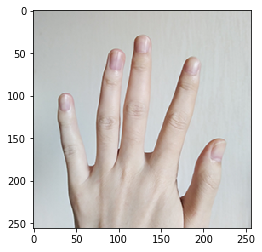

('image: ', '(256, 256, 3)')
('image_test shape:', '(256, 256, 3)')


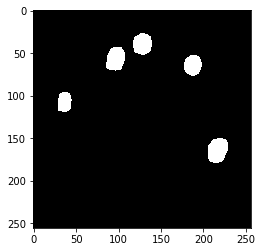

In [67]:
sess = K.get_session()
for num in range(11,12):
    path_s = "data/test/"
    path = path_s + str(num) + ".bmp"
    path_save = "data/save/" + str(num) + "_s.jpg"
    image = img.imread(path)  
    plt.imshow(image)
    plt.show()
    print("image: ", str(image.shape))
    image_test = image[:,:,:]  
    print("image_test shape:", str(image_test.shape))   
    image = image_test.reshape(1,image_test.shape[0],image_test.shape[1],3)   
    res = model.predict(image)
    amin, amax = res.min(),res.max()
    image = (res - amin) / (amax - amin) * 255.0
    image = image[0,...]
    image = image.reshape((256,256))
    fix_mask1(image)
    plt.imshow(image, cmap = plt.get_cmap('gray'))
    plt.show()
    img.imsave(path_save, np.uint8(image))

In [65]:
#####################################################H52Pb模型转换############################################################
from keras.models import load_model
import tensorflow as tf
import os 
import os.path as osp
from keras import backend as K
#路径参数
input_path = 'input path'
weight_file = 'nail_segment.h5'#portrait_segnet.h5'
weight_file_path = osp.join(input_path,weight_file)
output_graph_name = weight_file[:-3] + '.pb'
#转换函数
def h5_to_pb(h5_model,output_dir,model_name,out_prefix = "output_",log_tensorboard = True):
    if osp.exists(output_dir) == False:
        os.mkdir(output_dir)
    out_nodes = []
    for i in range(len(h5_model.outputs)):
        out_nodes.append(out_prefix + str(i + 1))
        tf.identity(h5_model.output[i],out_prefix + str(i + 1))
    sess = K.get_session()
    from tensorflow.python.framework import graph_util,graph_io
    init_graph = sess.graph.as_graph_def()
    main_graph = graph_util.convert_variables_to_constants(sess,init_graph,out_nodes)
    graph_io.write_graph(main_graph,output_dir,name = model_name,as_text = False)
    if log_tensorboard:
        from tensorflow.python.tools import import_pb_to_tensorboard
        import_pb_to_tensorboard.import_to_tensorboard(osp.join(output_dir,model_name),output_dir)
#输出路径
output_dir = osp.join(os.getcwd(),"trans_model")
#加载模型
h5_to_pb(model,output_dir = output_dir,model_name = output_graph_name)
print('model saved')

INFO:tensorflow:Froze 46 variables.
INFO:tensorflow:Converted 46 variables to const ops.
Model Imported. Visualize by running: tensorboard --logdir=/home/shuofeng/AIProject/UnetFaceSegment/trans_model
model saved
